# Домашнее задание по обучению с подкреплением

## Задача

Использовать среду **Taxi** из фреймворка [OpenAI Gym](https://gym.openai.com/envs/Taxi-v3/), реализовать алгоритм поиска оптимальной стратегии и оценить её эффективность.

---

## Этапы выполнения

1. **Анализ среды**
   - Определить и описать:
     - Пространство состояний
     - Пространство действий
     - Правила награждения (reward function)

2. **Реализация алгоритма**
   - Выбрать и реализовать один из следующих алгоритмов:
     - Value Iteration
     - Policy Iteration
     - Monte Carlo
     - SARSA
     - Q-learning

3. **Оценка стратегии**
   - Получить оптимальную стратегию
   - Провести **10 000 эпизодов** с использованием этой стратегии
   - Вывести:
     - Среднюю награду за эпизод
     - (опционально) Количество "побед" (успешных завершений миссии)

4. **Визуализация**
   - Визуализировать **один эпизод** игры с оптимальной стратегией


-------------------------------------------------------------------------------------------------

In [1]:
import gym
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm  # для отображения прогресса в циклах обучения
import warnings

warnings.filterwarnings("ignore")

In [2]:
import gymnasium as gym

==========================================================================================================

## Описание среды: Taxi-v3

### Общая идея

В этой среде агент управляет такси, которое должно:

1. **Забрать пассажира** в одной из четырёх фиксированных точек на карте.
2. **Доставить пассажира** в другую заданную точку.

Цель агента — выполнить задачу **максимально быстро**, совершая **как можно меньше шагов** и **избегая штрафов**.

---

### Состояния

Полное состояние кодируется **одним целым числом** от `0` до `499` и представляет собой комбинацию:

- Позиции такси на сетке `5 × 5` (всего 25 возможных позиций),
- Текущего местоположения пассажира (одна из 4 точек либо в такси — итого 5 вариантов),
- Целевого пункта назначения (4 возможных точки).

Общее число состояний: `25 (позиций такси) × 5 (положение пассажира) × 4 (цели) = 500`.

---

### Действия

Агент может выполнять **6 дискретных действий**:

| Код | Действие         |
|-----|------------------|
| 0   | Движение на юг   |
| 1   | Движение на север|
| 2   | Движение на восток |
| 3   | Движение на запад |
| 4   | Забрать пассажира (pickup) |
| 5   | Высадить пассажира (dropoff) |

---

### Награды (Rewards)

- `+20` — успешная доставка пассажира в нужное место.
- `-1` — каждое перемещение (шаг), включая неудачные pickup/dropoff.
- `-10` — попытка забрать или высадить пассажира в неправильном месте.

---

### Завершение эпизода

Эпизод завершается, когда пассажир успешно доставлен в пункт назначения.

---

### Цель агента

Разработать стратегию (policy), которая **минимизирует общее количество шагов** и **избегает штрафов**, чтобы **максимизировать суммарную награду**.


========================================================================================================

In [3]:
env = gym.make("Taxi-v3", render_mode="ansi")

state, info = env.reset()
print("Начальное состояние:", state)  # всега разное

Начальное состояние: 291


In [4]:
print("Пространство состояний:", env.observation_space)
print("Пространство действий:", env.action_space)
print("Число возможных действий:", env.action_space.n)
print("Число возможных состояний:", env.observation_space.n)
print("Является ли 3 допустимым действием?", env.action_space.contains(3))
print("Является ли 499 допустимым состоянием?", env.observation_space.contains(499))

Пространство состояний: Discrete(500)
Пространство действий: Discrete(6)
Число возможных действий: 6
Число возможных состояний: 500
Является ли 3 допустимым действием? True
Является ли 499 допустимым состоянием? True


In [5]:
# симуляция шага
action = 0  # например, "движение на юг"
next_state, reward, terminated, truncated, info = env.step(action)

done = terminated or truncated

print("Следующее состояние:", next_state)
print("Награда:", reward)
print("Завершено ли эпизод:", done)

Следующее состояние: 391
Награда: -1
Завершено ли эпизод: False


In [6]:
# Отобразить текущее состояние (текстом)
print(env.render())

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)



==============================================================================================================

In [7]:
def train_q_learning(env, num_episodes=10000, alpha=0.1, gamma=0.99,
                     epsilon=1.0, epsilon_decay=0.9995, epsilon_min=0.1,
                     visualize=True, if_testing=True, test_episodes=1000):
    """
    Обучение Q-learning с визуализацией и последующим тестированием на новой выборке.
    """
    n_states = env.observation_space.n
    n_actions = env.action_space.n
    Q = np.zeros((n_states, n_actions))

    total_rewards = []
    avg_rewards = []
    successful_episodes = 0

    for episode in tqdm(range(num_episodes), desc="Обучение Q-learning"):
        state, _ = env.reset()
        done = False
        total_reward = 0

        while not done:
            if random.random() < epsilon:
                action = env.action_space.sample()
            else:
                action = np.argmax(Q[state])

            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            best_next = np.max(Q[next_state])
            Q[state, action] += alpha * (reward + gamma * best_next - Q[state, action])

            state = next_state
            total_reward += reward

        total_rewards.append(total_reward)
        avg_rewards.append(np.mean(total_rewards))

        if reward == 20:
            successful_episodes += 1

        if epsilon > epsilon_min:
            epsilon *= epsilon_decay

    print(f"\n📈 Средняя награда за эпизод (обучение): {avg_rewards[-1]:.2f}")
    print(f"✅ Успешных эпизодов: {successful_episodes} из {num_episodes}")

    if if_testing:
        test_rewards = []
        successful_test_episodes = 0

        for _ in range(test_episodes):
            state, _ = env.reset()
            done = False
            episode_reward = 0
    
            while not done:
                action = np.argmax(Q[state])
                next_state, reward, terminated, truncated, _ = env.step(action)
                done = terminated or truncated
                state = next_state
                episode_reward += reward
    
            test_rewards.append(episode_reward)
            if reward == 20:  # успешная доставка
                successful_test_episodes += 1
    
        avg_test_reward = np.mean(test_rewards)
        print(f"\n🧪 Средняя награда на тесте ({test_episodes} эпизодов): {avg_test_reward:.2f}")
        print(f"🏁 Успешных эпизодов на тесте: {successful_test_episodes} из {test_episodes}")


    if visualize:
        plt.figure(figsize=(10, 4))
        plt.plot(avg_rewards)
        plt.xlabel("Эпизод")
        plt.ylabel("Средняя награда")
        plt.title("Динамика средней награды")
        plt.grid(True)
        plt.tight_layout()
        plt.show()


    return Q, avg_rewards


Обучение Q-learning: 100%|█████████████████████████████████████████████████████| 10000/10000 [00:06<00:00, 1574.10it/s]



📈 Средняя награда за эпизод (обучение): -50.80
✅ Успешных эпизодов: 9556 из 10000

🧪 Средняя награда на тесте (1000 эпизодов): 7.92
🏁 Успешных эпизодов на тесте: 1000 из 1000


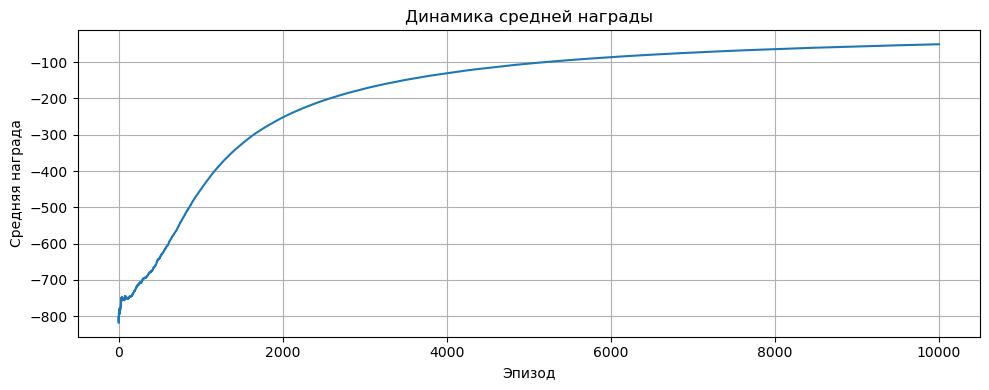

In [8]:
Q_table, _ = train_q_learning(env)

## Обозначения параметров `passenger` и `destination` в среде Taxi-v3

### 🚕 Параметр `passenger`

Этот параметр определяет, **где сейчас находится пассажир**:

| Значение | Расшифровка                       |
|----------|-----------------------------------|
| `0`      | Пассажир находится в точке `R` (Red) — `(0, 0)` |
| `1`      | Пассажир находится в точке `G` (Green) — `(0, 4)` |
| `2`      | Пассажир находится в точке `Y` (Yellow) — `(4, 0)` |
| `3`      | Пассажир находится в точке `B` (Blue) — `(4, 3)` |
| `4`      | 🧍‍♂️ Пассажир **уже в такси** (после действия `pickup`) |

---

### 🎯 Параметр `destination`

Этот параметр определяет, **куда нужно отвезти пассажира**:

| Значение | Расшифровка                       |
|----------|-----------------------------------|
| `0`      | Цель — точка `R` (Red) — `(0, 0)` |
| `1`      | Цель — точка `G` (Green) — `(0, 4)` |
| `2`      | Цель — точка `Y` (Yellow) — `(4, 0)` |
| `3`      | Цель — точка `B` (Blue) — `(4, 3)` |

---

### 💡 Примеры:

- `passenger=0, destination=1` → пассажир ждёт в `R`, цель — `G`
- `passenger=4, destination=1` → пассажир **уже в такси**, нужно везти в `G`


In [9]:
def heatmap_5x5_strategy(Q, env, passenger=0, destination=1):
    """
    Визуализация стратегии Q-learning на 5x5 карте.
    Показывает стрелки для действий, заливку только для P/D и точек назначения.
    """
    action_symbols = {
        0: "↓", 1: "↑", 2: "→", 3: "←", 4: "P", 5: "D"
    }

    action_colors = {
        4: "#F9E79F",  # P
        5: "#F1948A",  # D
    }

    landmark_colors = {
        (0, 0): "#F5B7B1",  # R
        (0, 4): "#ABEBC6",  # G
        (4, 0): "#FCF3CF",  # Y
        (4, 3): "#AED6F1",  # B
    }

    symbol_map = np.empty((5, 5), dtype=object)
    color_map = np.full((5, 5), "#FFFFFF", dtype=object)  # белый фон по умолчанию

    for row in range(5):
        for col in range(5):
            state = env.unwrapped.encode(row, col, passenger, destination)
            action = np.argmax(Q[state])
            symbol_map[row, col] = action_symbols[action]

            if action in action_colors:
                color_map[row, col] = action_colors[action]

    for (r, c), color in landmark_colors.items():
        color_map[r, c] = color

    fig, ax = plt.subplots(figsize=(6, 6))

    for row in range(5):
        for col in range(5):
            rect = plt.Rectangle((col, row), 1, 1,
                                 facecolor=color_map[row, col], edgecolor='black')
            ax.add_patch(rect)

            symbol = symbol_map[row, col]
            ax.text(col + 0.5, row + 0.5, symbol,
                    ha='center', va='center', fontsize=16)

    ax.set_xlim(0, 5)
    ax.set_ylim(0, 5)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.invert_yaxis()

    ax.set_title(f"Стратегия Q-learning (пассажир: {passenger}, цель: {destination})", pad=20)

    legend_text = "P — забрать пассажира   D — высадить пассажира"
    plt.figtext(0.5, -0.04, legend_text, ha="center", fontsize=10)

    plt.tight_layout()
    plt.show()

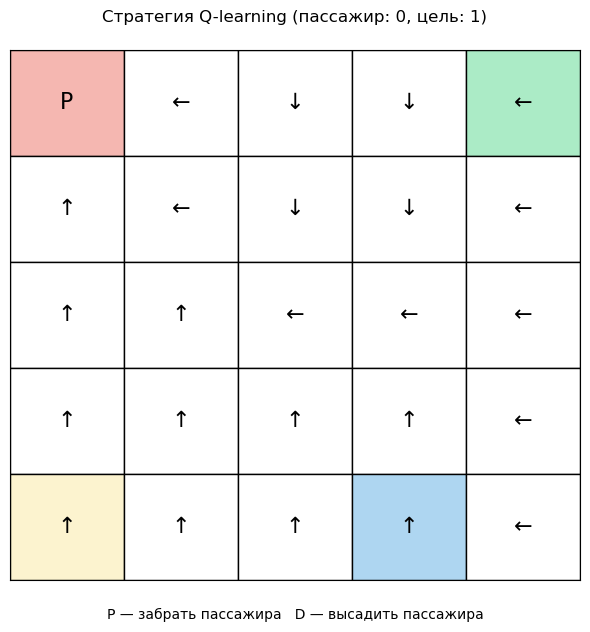

In [10]:
heatmap_5x5_strategy(Q_table, env, passenger=0, destination=1)

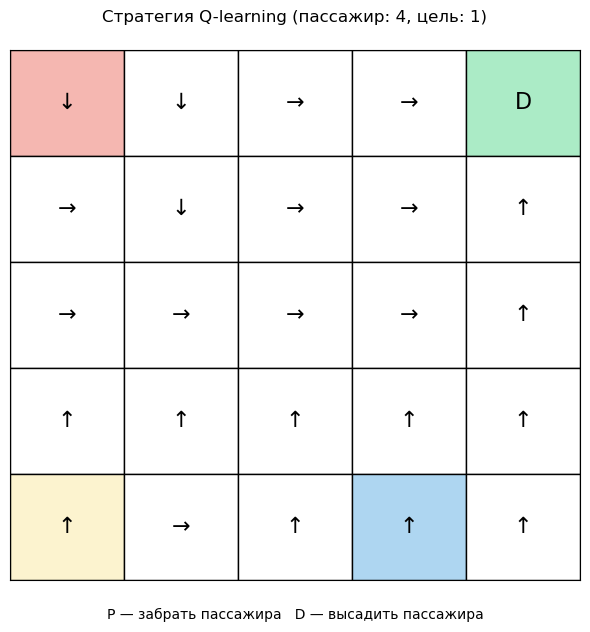

In [11]:
heatmap_5x5_strategy(Q_table, env, passenger=4, destination=1)

In [12]:
from IPython.display import display, clear_output

def play_episode_graphical(Q, max_steps=100, delay=0.5):
    """
    Проигрывает один эпизод Taxi-v3, отображая каждое состояние как изображение.
    Обновляет одну и ту же картинку (через matplotlib + rgb_array).
    """
    import time
    import gymnasium as gym

    env = gym.make("Taxi-v3", render_mode="rgb_array")
    state, _ = env.reset()
    done = False
    total_reward = 0
    step = 0

    plt.ion()
    fig, ax = plt.subplots()

    while not done and step < max_steps:
        frame = env.render()
        ax.clear()
        ax.imshow(frame)
        ax.set_title(f"Шаг {step}")
        ax.axis("off")
        display(fig)
        clear_output(wait=True)

        action = np.argmax(Q[state])
        state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        total_reward += reward
        step += 1
        time.sleep(delay)

    plt.ioff()
    frame = env.render()
    ax.clear()
    ax.imshow(frame)
    ax.set_title(f"Готово! Шагов: {step}, Награда: {total_reward}")
    ax.axis("off")
    env.close()

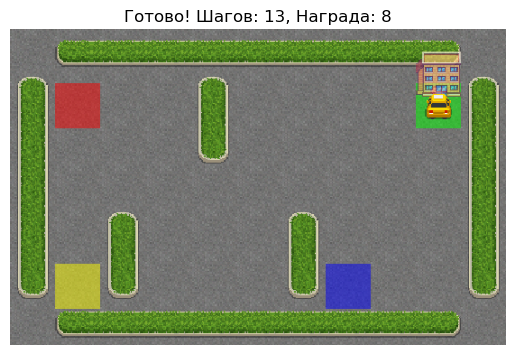

In [13]:
play_episode_graphical(Q_table)